## Visualize ECCO volume budget from Ivana Cerovecki

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [34]:
# Load ecco
# This netcdf created from data provided by IC in load_ecco.py
# Original data here: 
# '/local/projects/so_decadal_variability/ECCOv4r4/binned_vol_budget_gamma/'
# The original data have been manipulated to return a value for WMT, by
# multiplying by rho0 (1024.5 for ecco) and dividing by \delta\gamma (0.1)
rootdir = './'
localdir = 'data/'
filename = 'binned_vol_budget_month_dGamman_0.1.nc'
ecco = xr.open_dataset(rootdir+localdir+filename).drop('bin_vol')
terms = ecco.data_vars
signs = {'bin_ADV':1,'bin_DIF':1,'bin_FORC':1,'bin_TEN':-1}
# Remove obscure values in early years and late years
ecco=ecco.sel({'time':slice('1994-01-01','2016-12-31')})

### Full balance

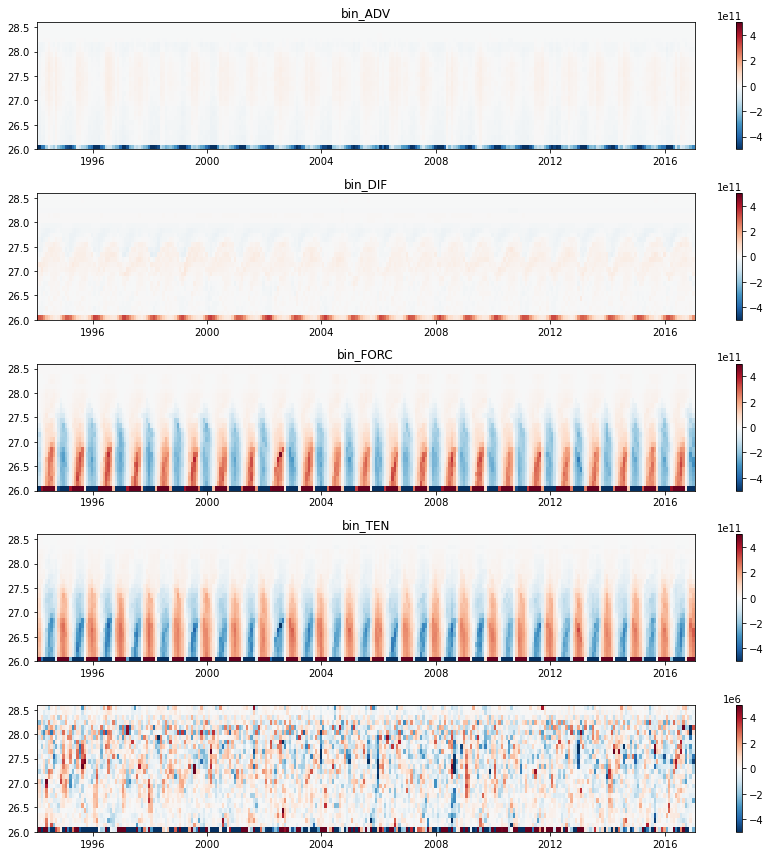

In [35]:
residual = xr.zeros_like(ecco['bin_ADV'])
clims = [-5E11, 5E11]
precision = 1E-5
fig,ax = plt.subplots(figsize = (12,12), nrows = len(ecco.data_vars)+1)
count = 0
for term in terms:
    sign=signs[term]
    axnow = ax[count]
    im = axnow.pcolormesh(ecco['time'],ecco['gamma_n'],
                          sign*ecco[term],
                          vmin=clims[0],vmax=clims[1],cmap='RdBu_r',
                          shading='auto')
    axnow.set_title(term)
    plt.colorbar(im,ax=axnow)

    residual += sign*ecco[term]
    count+=1
        
im = ax[count].pcolormesh(residual['time'],residual['gamma_n'],
                          residual,
                          vmin=clims[0]*precision,vmax=clims[1]*precision,
                          cmap='RdBu_r',
                         shading='auto')
plt.colorbar(im,ax=ax[count])

plt.tight_layout()

### Annual anomaly balance

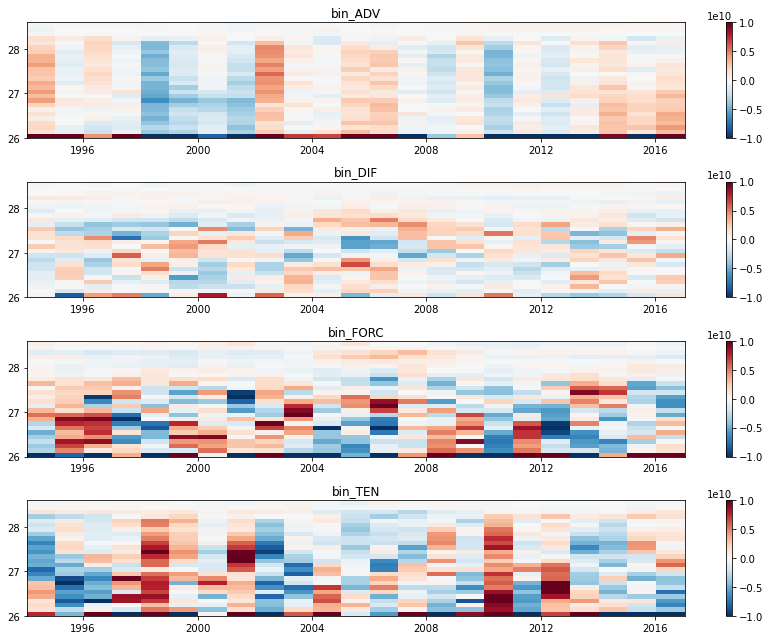

In [37]:
def calc_annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom

ecco_annanom = xr.Dataset()

clims = [-1E10, 1E10]
fig,ax = plt.subplots(figsize = (12,9), nrows = len(ecco.data_vars))
count=0
for term in terms:
    sign=signs[term]
    ecco_annanom[term] = calc_annualanom(ecco[term])
    
    axnow = ax[count]
    im = axnow.pcolormesh(ecco_annanom[term]['time'],
                          ecco_annanom[term]['gamma_n'],
                          sign*ecco_annanom[term],
                          vmin=clims[0],vmax=clims[1],cmap='RdBu_r',
                          shading='auto')
    axnow.set_title(term)
    plt.colorbar(im,ax=axnow)

    count+=1
        
plt.tight_layout()

### Across a specific neutral surface

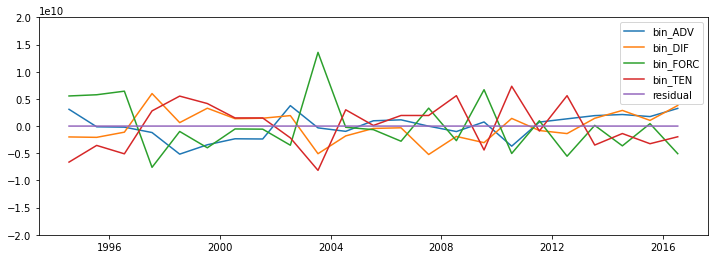

In [38]:
gammaT = 27
residual = xr.zeros_like(ecco_annanom['bin_ADV'].sel(gamma_n=gammaT,method='nearest'))
fig,ax = plt.subplots(figsize=(12,4))
for term in terms:
    sign=signs[term]
    value = sign*ecco_annanom[term].sel(gamma_n=gammaT,method='nearest')
    ax.plot(ecco_annanom['time'],value,label=term)

    residual += value
        
ax.plot(residual['time'],residual,label='residual')
ax.set_ylim([-2E10, 2E10])
ax.legend()

### Time-mean picture

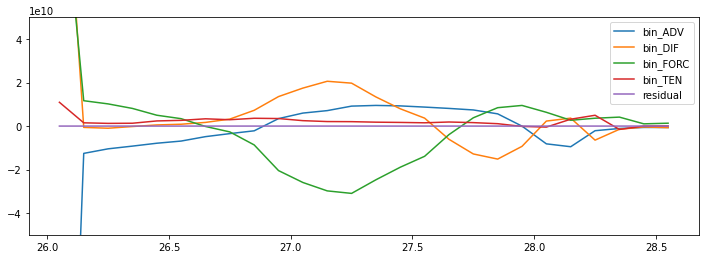

In [39]:
residual = xr.zeros_like(ecco['bin_ADV'].mean('time'))
fig,ax = plt.subplots(figsize=(12,4))
for term in terms:
    sign=signs[term]
    value = sign*ecco[term].mean('time')
    ax.plot(ecco['gamma_n'],value,label=term)
    residual += value
        
ax.plot(residual['gamma_n'],residual,label='residual')
ax.set_ylim([-5E10, 5E10])
ax.legend()

### Does tendency + forcing = advection ?

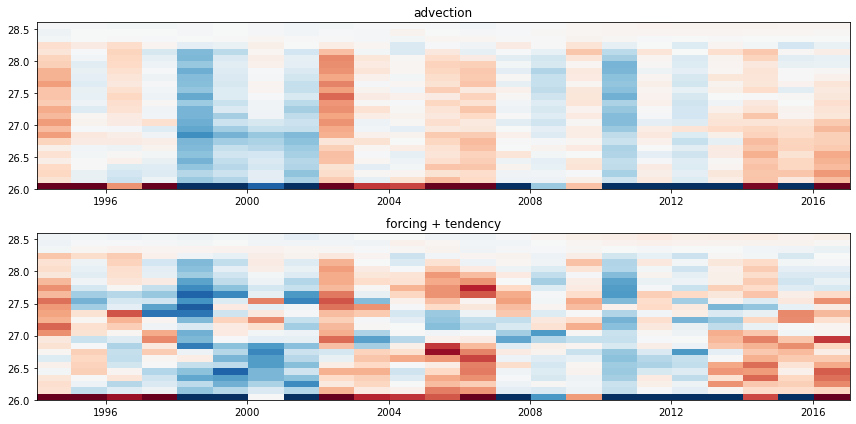

In [53]:
ADV = signs['bin_ADV']*ecco_annanom['bin_ADV']
ADV_est = -1*(signs['bin_FORC']*ecco_annanom['bin_FORC']+signs['bin_TEN']*ecco_annanom['bin_TEN'])

clims = [-1E10, 1E10]
fig,ax = plt.subplots(figsize=(12,6),nrows=2)
ax[0].pcolormesh(ADV['time'],ADV['gamma_n'],ADV,
                 cmap='RdBu_r',vmin=clims[0],vmax=clims[1],shading='auto')
ax[0].set_title('advection')
ax[1].pcolormesh(ADV_est['time'],ADV_est['gamma_n'],ADV_est,
                 cmap='RdBu_r',vmin=clims[0],vmax=clims[1],shading='auto')
ax[1].set_title('forcing + tendency')
plt.tight_layout()

In [4]:
rootdir = 'data/'
filename = 'G.nc'
erai = xr.open_dataarray(rootdir+filename)

In [5]:
rootdir = '/local/projects/so_decadal_variability/OM4/'
filename = 'gamma_n_0.1.G.nc'
om4 = xr.open_dataset(rootdir+filename)['total']

In [6]:
start = '1992-01-01'
end = '2017-12-31'
dates = pd.date_range(start,end,freq='1M')

In [7]:
def calc_annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom

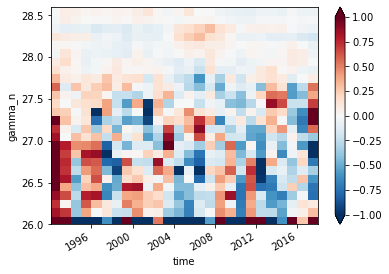

In [14]:
ecco_annualanom = calc_annualanom(ecco)
(ecco_annualanom*1E-6).plot(vmin=-1)

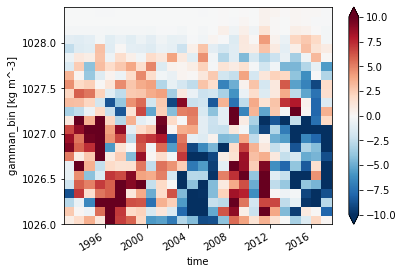

In [13]:
erai_annualanom = calc_annualanom(erai.sel(time=slice(start,end)))
(erai_annualanom*1E-9).transpose().plot(vmin=-10)

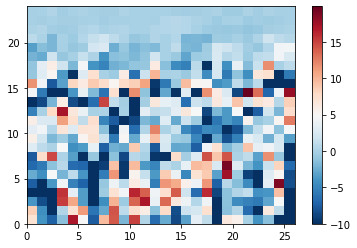

In [18]:
om4_annualanom = om4.sel(time=slice(start,end))-om4.sel(time=slice(start,end)).mean('time')
im = plt.pcolormesh((om4_annualanom*1E-9).transpose(),cmap='RdBu_r',vmin=-10)
plt.colorbar(im)